In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization
from g_media_pipe import extract_data_from_video, save_data
import ast
import glob
import os

In [2]:
directory = os.path.join("model_data", "Squats","Proper")
csv_files = glob.glob(os.path.join(directory, "*.csv"))

In [3]:
csv_files

['model_data\\Squats\\Proper\\properSquat1.csv',
 'model_data\\Squats\\Proper\\ProperSquat10.csv',
 'model_data\\Squats\\Proper\\ProperSquat3.csv',
 'model_data\\Squats\\Proper\\ProperSquat4.csv',
 'model_data\\Squats\\Proper\\ProperSquat5.csv',
 'model_data\\Squats\\Proper\\ProperSquat6.csv',
 'model_data\\Squats\\Proper\\ProperSquat7.csv',
 'model_data\\Squats\\Proper\\ProperSquat8.csv',
 'model_data\\Squats\\Proper\\ProperSquat9.csv',
 'model_data\\Squats\\Proper\\Proper_Squat_1.csv']

In [4]:
calibration_squat = pd.read_csv(csv_files[0])
calibration_squat.head()

,NOSE,LEFT_EYE_INNER,LEFT_EYE,LEFT_EYE_OUTER,RIGHT_EYE_INNER,RIGHT_EYE,RIGHT_EYE_OUTER,LEFT_EAR,RIGHT_EAR,MOUTH_LEFT,...,LEFT_HIP,RIGHT_HIP,LEFT_KNEE,RIGHT_KNEE,LEFT_ANKLE,RIGHT_ANKLE,LEFT_HEEL,RIGHT_HEEL,LEFT_FOOT_INDEX,RIGHT_FOOT_INDEX
0,"[0.4244316816329956, 0.22050920128822327, -0.4...","[0.4397614896297455, 0.2081490010023117, -0.40...","[0.44688543677330017, 0.20820307731628418, -0....","[0.45620349049568176, 0.20851349830627441, -0....","[0.4105842709541321, 0.20872071385383606, -0.4...","[0.40054112672805786, 0.20926599204540253, -0....","[0.39335381984710693, 0.2100338488817215, -0.4...","[0.46951591968536377, 0.21445703506469727, -0....","[0.38441023230552673, 0.2165108174085617, -0.2...","[0.44251561164855957, 0.23559340834617615, -0....",...,"[0.5063880681991577, 0.49203425645828247, 0.02...","[0.38032233715057373, 0.49639230966567993, -0....","[0.533027172088623, 0.6365314722061157, -0.002...","[0.3569492697715759, 0.638127863407135, 0.0328...","[0.5481680035591125, 0.736966609954834, 0.4402...","[0.35661524534225464, 0.7428156137466431, 0.47...","[0.5332619547843933, 0.7448287010192871, 0.470...","[0.3717019855976105, 0.7504509687423706, 0.502...","[0.5719988346099854, 0.7900164127349854, 0.257...","[0.3386213183403015, 0.7929822206497192, 0.285..."
1,"[0.4235227406024933, 0.21684443950653076, -0.3...","[0.43903201818466187, 0.20470984280109406, -0....","[0.4468555152416229, 0.20477037131786346, -0.3...","[0.45540836453437805, 0.2048829048871994, -0.3...","[0.40920841693878174, 0.20490750670433044, -0....","[0.3998473286628723, 0.20540988445281982, -0.3...","[0.39174339175224304, 0.20587685704231262, -0....","[0.46900367736816406, 0.21041497588157654, -0....","[0.3836110830307007, 0.21121135354042053, -0.1...","[0.44183802604675293, 0.23266153037548065, -0....",...,"[0.5062860250473022, 0.49120384454727173, 0.01...","[0.38026949763298035, 0.49634894728660583, -0....","[0.5337517857551575, 0.6302443742752075, 0.024...","[0.35608652234077454, 0.6357370018959045, 0.09...","[0.5482008457183838, 0.7303119897842407, 0.440...","[0.35652613639831543, 0.7375196814537048, 0.49...","[0.5332834124565125, 0.7388057112693787, 0.470...","[0.37171733379364014, 0.7449566125869751, 0.52...","[0.5711283683776855, 0.7814869284629822, 0.271...","[0.33687734603881836, 0.7879244089126587, 0.34..."
2,"[0.4227296710014343, 0.2085539996623993, -0.32...","[0.43831613659858704, 0.1960284262895584, -0.2...","[0.44676488637924194, 0.1961459219455719, -0.2...","[0.4543534517288208, 0.1967248022556305, -0.29...","[0.40825068950653076, 0.1967441439628601, -0.2...","[0.39929160475730896, 0.19713343679904938, -0....","[0.39012810587882996, 0.19783255457878113, -0....","[0.4673558175563812, 0.2034216821193695, -0.10...","[0.38233980536460876, 0.20453612506389618, -0....","[0.4414278566837311, 0.22501909732818604, -0.2...",...,"[0.5055862665176392, 0.489584743976593, 0.0137...","[0.38004928827285767, 0.4954547882080078, -0.0...","[0.5339826345443726, 0.6249909400939941, 0.007...","[0.35355886816978455, 0.6311861276626587, 0.03...","[0.5480718016624451, 0.7260529398918152, 0.353...","[0.3564785122871399, 0.7328090071678162, 0.314...","[0.5322403311729431, 0.7342929244041443, 0.377...","[0.37170639634132385, 0.7412026524543762, 0.33...","[0.570963978767395, 0.7752067446708679, 0.2085...","[0.33661699295043945, 0.7841972708702087, 0.16..."
3,"[0.42150789499282837, 0.20228520035743713, -0....","[0.4364469349384308, 0.18947520852088928, -0.2...","[0.4458343982696533, 0.1896168440580368, -0.26...","[0.452472060918808, 0.19035115838050842, -0.26...","[0.4065835177898407, 0.18994715809822083, -0.2...","[0.39792320132255554, 0.1900908648967743, -0.2...","[0.3879556357860565, 0.19088976085186005, -0.2...","[0.4640847146511078, 0.19738951325416565, -0.0...","[0.380149245262146, 0.19864614307880402, -0.10...","[0.4403133690357208, 0.2188064306974411, -0.21...",...,"[0.5046833753585815, 0.4868897497653961, 0.010...","[0.378551185131073, 0.49287357926368713, -0.0

In [5]:
def euclidean(joint1,joint2):
        joint1 = eval(joint1)
        joint2 = eval(joint2)
        xi,yi,zi = joint1
        xj,yj,zj = joint2
        return (np.square(xi-xj)+np.square(yi-yj)+np.square(zi-zj))**0.5

def calculate_joint_angle(a,b,c):
    """
    Computes 3D joint angle inferred by 3 keypoints and their relative positions to one another
    
    """
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

# def compute_row(row):
#         n = len(row)
#         output = np.zeros((33,33))
#         for i in range(n):
#             for j in range(n):
#                    output[i][j] = euclidean(row.iloc[i],row.iloc[j])
#         return output[np.triu_indices(33,k=1)]
        
# matrix = df.apply(lambda row: compute_row(row),axis=1)
# print(matrix.shape)
#matrix[np.triu_indices(33, k=1)].shape

In [6]:
class VideoProcessingPipeline: 
    """
    Class for identifying the number of squats done in a .mp4 video
    """
    def __init__(self,video_file_path:str,threshold:float = 0.25) -> None:
        self.threshold = threshold
        raw_data = extract_data_from_video(video_path=video_file_path)
        df = pd.DataFrame(raw_data).drop(['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER',
       'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER', 'LEFT_EAR',
       'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT', 'LEFT_SHOULDER',
       'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW', 'LEFT_WRIST',
       'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX','LEFT_THUMB', 'RIGHT_THUMB','LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_HEEL', 'RIGHT_HEEL',
       'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX'],axis=1)
        processed_df = self.process_df(df)
        for col in processed_df.columns:
            processed_df[col] = self.smooth_gaussian(self.min_max_scaler(processed_df[col]))
        self.data = processed_df
        
    def process_df(self,data:pd.DataFrame) -> pd.DataFrame:
        if isinstance(data.iloc[0][0],str):
            data = data.map(ast.literal_eval)

        x_coors = data.map(lambda coords: coords[0])  # Get the X coordinates
        y_coors = data.map(lambda coords: coords[1])  # Get the Y coordinates
        z_coors = data.map(lambda coords: coords[2])  # Get the Z coordinates

        # If you want to combine these into a single DataFrame with columns like NOSE_x, NOSE_y, NOSE_z, etc.
        x_coors.columns = [f'{col}_x' for col in x_coors.columns]
        y_coors.columns = [f'{col}_y' for col in y_coors.columns]
        z_coors.columns = [f'{col}_z' for col in z_coors.columns]
        # Combine the x, y, z data into a single DataFrame
        return pd.concat([x_coors, y_coors, z_coors], axis=1)
    
    def min_max_scaler(self,col:pd.Series)->pd.Series:
        min_value = np.min(col)
        max_value = np.max(col)
        return col.map(lambda x: (x-min_value)/(max_value-min_value))
    
    def smooth_gaussian(self,data:pd.Series, sigma=2)->pd.Series:
        """
        Smoothen the curves using a Gaussian filter.

        Parameters:
        - data: NumPy array, the input signal to smooth.
        - sigma: Standard deviation of the Gaussian kernel.

        Returns:
        - smoothed_data: NumPy array of the smoothed data.
        """
        kernel_radius = int(3 * sigma)  # 3 standard deviations cover ~99% of data
        x = np.arange(-kernel_radius, kernel_radius + 1)
        gaussian_kernel = np.exp(-x**2 / (2 * sigma**2))
        gaussian_kernel /= gaussian_kernel.sum()  # Normalize the kernel
        
        # Padding to avoid edge effects
        padded_data = np.pad(data, pad_width=kernel_radius, mode='edge')
        
        # Convolution with Gaussian kernel
        smoothed_data = np.convolve(padded_data, gaussian_kernel, mode='valid')
        
        return smoothed_data
    
    def count_reps(self):
        left_knee_count = right_knee_count = 0
        right_knee_col = self.data['RIGHT_KNEE_z']
        left_knee_col = self.data['LEFT_KNEE_z']
        for i in range(len(right_knee_col)-1):
            if right_knee_col[i] > self.threshold and right_knee_col[i+1] <= self.threshold:
                right_knee_count += 1
            if left_knee_col[i] > self.threshold and left_knee_col[i+1] <= self.threshold:
                left_knee_count += 1
        return (left_knee_count,right_knee_count)

In [8]:
# read a new mp4 file and count the number of reps
pipeline = VideoProcessingPipeline(r"D:\NirwanaWarehouse\uniWork\Term 7\Capstone\backend\FITTR_WEBSOCKET\datasets\Test\Exercise Library_ Squats_8_reps.mp4")
#save_data(videoData=video_data,output_path=r"D:\NirwanaWarehouse\uniWork\Term 7\Capstone\backend\datasets\Test\Squats_8_reps.csv")
pipeline.data.head()

Extracting data from video file: D:\NirwanaWarehouse\uniWork\Term 7\Capstone\backend\FITTR_WEBSOCKET\datasets\Test\Exercise Library_ Squats_8_reps.mp4


d:\Anaconda\envs\capstone\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\Users\saran\AppData\Local\Temp\ipykernel_18376\1929455758.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(data.iloc[0][0],str):


,LEFT_HIP_x,RIGHT_HIP_x,LEFT_KNEE_x,RIGHT_KNEE_x,LEFT_HIP_y,RIGHT_HIP_y,LEFT_KNEE_y,RIGHT_KNEE_y,LEFT_HIP_z,RIGHT_HIP_z,LEFT_KNEE_z,RIGHT_KNEE_z
0,0.105152,0.125273,0.675493,0.825010,0.108020,0.083493,0.263508,0.307660,0.564949,0.437504,0.974586,0.798362
1,0.103222,0.115526,0.672633,0.824720,0.108285,0.083348,0.260911,0.306717,0.552849,0.449738,0.961505,0.814956
2,0.100650,0.105219,0.668523,0.824275,0.108608,0.083082,0.257170,0.305903,0.538010,0.464710,0.949616,0.830774
3,0.097631,0.096078,0.663375,0.823620,0.108915,0.082649,0.252452,0.305209,0.522689,0.480138,0.941175,0.842375
4,0.094483,0.089057,0.657691,0.822663,0.109106,0.082018,0.247313,0.304306,0.509177,0.493718,0.936644,0.848285


In [9]:
pipeline.count_reps()

(8, 8)

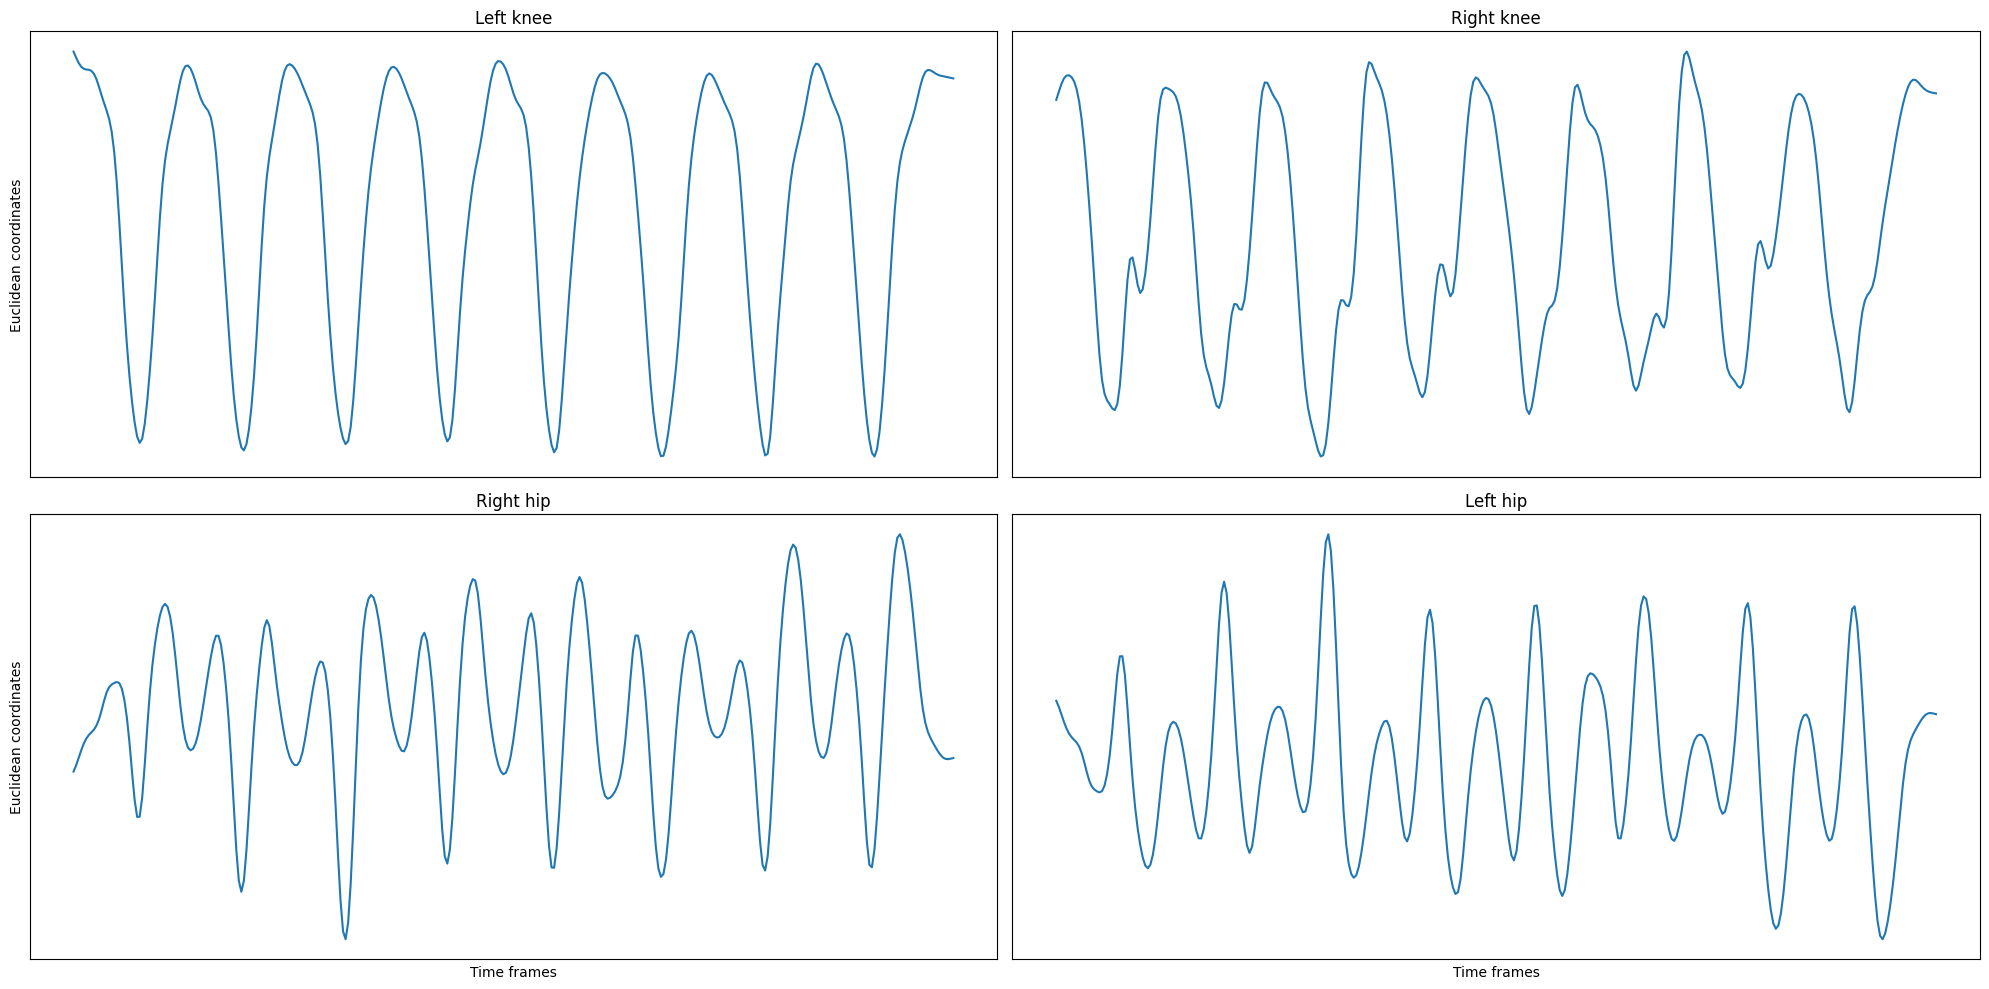

In [11]:
plt.figure(figsize=(20, 10))

# First row, first plot: LEFT_KNEE_z
plt.subplot(221)
plt.plot(pipeline.data['LEFT_KNEE_z'])
plt.title('Left knee')
plt.xticks([]), plt.yticks([])
plt.ylabel("Euclidean coordinates")

# First row, second plot: RIGHT_KNEE_z
plt.subplot(222)
plt.plot(pipeline.data['RIGHT_KNEE_z'])
plt.title('Right knee')
plt.xticks([]), plt.yticks([])

# Second row, first plot: RIGHT_HIP_z
plt.subplot(223)
plt.plot(pipeline.data['RIGHT_HIP_z'])
plt.title('Right hip')
plt.xticks([]), plt.yticks([])
plt.xlabel("Time frames")
plt.ylabel("Euclidean coordinates")

# Second row, second plot: LEFT_HIP_z
plt.subplot(224)
plt.plot(pipeline.data['LEFT_HIP_z'])
plt.title('Left hip')
plt.xticks([]), plt.yticks([])
plt.xlabel("Time frames")

plt.tight_layout()
plt.show()


In [12]:
df_test = pd.read_csv(r"D:\NirwanaWarehouse\uniWork\Term 7\Capstone\backend\live_stream_test2.csv")
df_test.head()

,LEFT_HIP_x,RIGHT_HIP_x,LEFT_KNEE_x,RIGHT_KNEE_x,LEFT_HIP_y,RIGHT_HIP_y,LEFT_KNEE_y,RIGHT_KNEE_y,LEFT_HIP_z,RIGHT_HIP_z,LEFT_KNEE_z,RIGHT_KNEE_z
0,0.780151,0.791435,0.784009,0.757191,0.722735,0.693268,0.673286,0.660333,0.655652,0.667875,0.700870,0.745381
1,0.783573,0.795627,0.788587,0.761635,0.726688,0.696645,0.676106,0.662512,0.656983,0.668185,0.700161,0.743821
2,0.787945,0.799685,0.791778,0.763566,0.727239,0.695983,0.674606,0.660763,0.655798,0.668616,0.703302,0.750366
3,0.789034,0.801321,0.793899,0.765896,0.729375,0.697599,0.675533,0.660967,0.655352,0.667750,0.702422,0.749910
4,0.791832,0.803994,0.796392,0.768268,0.731733,0.699938,0.677645,0.662580,0.656374,0.668393,0.703069,0.750891


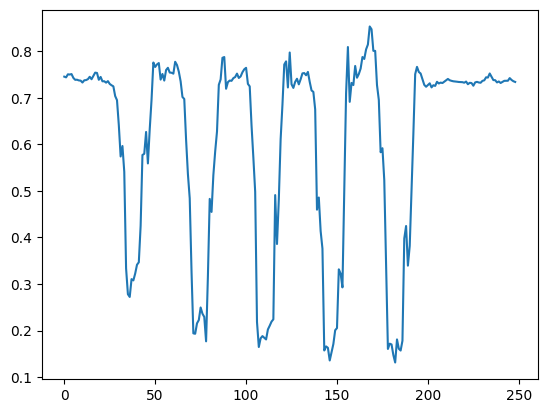

In [13]:
plt.plot(df_test["RIGHT_KNEE_z"])